# Interpretability II: Definitions of Interpretability

## Copyright notice

Parts of this code are adapted from https://open_nsfw.gitlab.io/code.py, (c) 2016 Gabriel Goh and https://github.com/Evolving-AI-Lab/synthesizing/blob/master/act_max.py, (c) 2016 Anh Nguyen, [MIT License](https://github.com/Evolving-AI-Lab/synthesizing/blob/master/LICENSE). This version (c) 2018 Fabian Offert, [MIT License](LICENSE).

## Background

Please see [Offert 2018].

## Docker

This example code is based on Gabriel Goh's [Image Synthesis from Yahoo's open_nsfw](https://open_nsfw.gitlab.io/) project, which is based on the [original implementation](https://github.com/Evolving-AI-Lab/synthesizing) of [Nguyen 2016], which is based on the [Caffe framework](http://caffe.berkeleyvision.org/). While I am working on a Keras implementation of the example code (which also requires the porting of the deep generator network from [Dosovitskiy 2016] and Yahoo's [open_nsfw model](https://github.com/yahoo/open_nsfw)), at this point it only works in Caffe. Hence, to run it, please use the [nsfw-docker container](https://github.com/zentralwerkstatt/AIWG/tree/master/nsfw-docker) provided in this repository, instead of the [keras-docker](https://github.com/zentralwerkstatt/AIWG/tree/master/keras-docker) container. The container is available in a GPU and CPU version. Due to limitations in the [nvidia-docker wrapper](https://github.com/NVIDIA/nvidia-docker), the GPU version only runs on Linux.

## Imports

We import the usual libraries and the Caffe framework.

In [16]:
import caffe
import numpy as np
import math, random
import sys, subprocess
from IPython.display import clear_output, Image, display
from scipy.misc import imresize
import scipy.misc, scipy.io
import os
from IPython.display import clear_output, Image, display
from io import BytesIO
import PIL.Image

## Settings

We have to tell Caffe explicitly where to run. Change this according to the nsfw-docker type you are using. We also load the models we will use: a deep generator network based on [Dosovitskiy 2016] trained to optimize "codes" based on the fc6 layer of CaffeNet, and open_nsfw. Note: the model definitions in Caffe are stored in external protocol buffer files called `deploy.prototxt`.

In [2]:
# caffe.set_mode_cpu()
caffe.set_mode_gpu()

# gp = "../synthesizing/nets/upconv/fc6/"
# tp = "../synthesizing/nets/open_nsfw/"
# ap = "../synthesizing/act_range/3x/fc6.txt"

gp = "/home/fabian/open_nsfw/synthesizing/nets/upconv/fc6/"
tp = "/home/fabian/open_nsfw/open_nsfw/nsfw_model/"
ap = "/home/fabian/open_nsfw/synthesizing/act_range/3x/fc6.txt"

generator = caffe.Net(gp + "generator.prototxt", gp + "generator.caffemodel", caffe.TEST)
classifier = caffe.Classifier(tp + "deploy.prototxt", tp + "resnet_50_1by2_nsfw.caffemodel", mean = np.float32([104.0, 117.0, 123.0]), channel_swap = (2,1,0))

## Image preprocessing and deprocessing

We are using the same image helper functions as in the ["Deep Dreaming" notebook](3-deepdream.ipynb) and the ["Feature Visualization" notebook](3-features.ipynb), with one exception: in the `deprocess_image` function, we have to switch the final result from BGR to RGB, as open_nsfw is based on a version of ResNet50, which operates in BGR.

In [10]:
def deprocess_image(x):
    h = x.shape[2]
    w = x.shape[3]
    n = np.zeros((h, w, 3))
    n[:] = x[0].copy().transpose((1,2,0))
    x = n
    x += 120.
    x /= 240.
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8') # Clip to visible range
    x = x[:,:,::-1] # BGR to RGB
    return x

# Simple save function based on scipy
def save_image(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)
    
def save_image_numbered(img, nr, folder):
    f = '{0:03d}'.format(nr)
    p = folder + '/' + f + '.jpg'
    save_image(img, p)
    
def show_image(img, fmt='jpeg'):
    img = deprocess_image(np.copy(img))
    f = BytesIO()
    PIL.Image.fromarray(img).save(f, fmt)
    display(Image(data=f.getvalue()))

## Additional image preprocessing and deprocessing

As the generator and the classifier operate on differently sized images, we also have to define two functions to crop and pad images.

In [11]:
def get_shape(data_shape):
    if len(data_shape) == 4:
        return (data_shape[2], data_shape[3])
    else:
        raise Exception("Data shape invalid.")

def crop(classifier, classifier_in, generator, generator_out, image):
    data_shape  = classifier.blobs[classifier_in].data.shape
    image_size  = get_shape(data_shape)
    output_size = get_shape(generator.blobs[generator_out].data.shape)
    topleft = ((output_size[0] - image_size[0])/2, (output_size[1] - image_size[1])/2)
    return image.copy()[:,:,topleft[0]:topleft[0]+image_size[0], topleft[1]:topleft[1]+image_size[1]]

def pad(classifier, classifier_in, generator, generator_out, image):
    data_shape  = classifier.blobs[classifier_in].data.shape
    image_size  = get_shape(data_shape)
    output_size = get_shape(generator.blobs[generator_out].data.shape)
    topleft = ((output_size[0] - image_size[0])/2, (output_size[1] - image_size[1])/2)
    o = np.zeros(generator.blobs[generator_out].data.shape)
    o[:,:,topleft[0]:topleft[0]+image_size[0], topleft[1]:topleft[1]+image_size[1]] = image
    return o

## Gradient ascent function

Commentary is provided inline.

In [12]:
def grad(classifier, 
         classifier_in, 
         classifier_out, 
         generator, 
         generator_in, 
         generator_out, 
         channel, 
         channel_opt, 
         code):

    # Generator forward pass: generator takes a code and outputs an image
    image = generator.forward(feat=code)[generator_out]
    
    # Crop the image so it fits the classifier
    image = crop(classifier, classifier_in, generator, generator_out, image)
    
    # Classifier forward pass
    actual_acts = classifier.forward(data=image, end=classifier_out)
    
    # Create *optimal* activations for the classifier's output layer (the fake ground truth)
    # np.ndarray.flat is just a 1D iterator over an array
    # In Caffe, .data is the data for a layer when the graph is running
    optimal_acts = np.zeros_like(classifier.blobs[classifier_out].data)
    optimal_acts.flat[channel] = channel_opt

    # We would like the last layer of the classifier to produce these optimal activations
    # In Caffe, .diff is the gradient for a layer when the graph is running
    classifier.blobs[classifier_out].diff[:] = optimal_acts
    
    # Classifier backward pass: from these optimal activations, we generate an image
    # Basically we backpropagate one layer to far to include the input layer
    optimal_image = classifier.backward(start=classifier_out, diffs=[classifier_in])[classifier_in][0] # ?

    # Cleanup
    classifier.blobs[classifier_out].diff.fill(0.)
    
    # Pad the image so it fits the generator
    optimal_image = pad(classifier, classifier_in, generator, generator_out, optimal_image)

    # We would like the last layer of the generator to produce this optimal image
    generator.blobs[generator_out].diff[...] = optimal_image
    
    # Generator backward pass: from this optimal image, we generate a code
    optimized_code = generator.backward(start=generator_out)[generator_in]

    # Cleanup
    generator.blobs[generator_out].diff.fill(0.)
    
    return optimized_code, image

## Hyperparameters

In [14]:
max_img = 5
total_iters = 300
alpha = 1.0
NSFW = 1
SFW = 0
FOLDER = 'results'

## Activation maximization with natural image prior

We now run the algorithm, starting with a random "code" which we optimize for `iterations` iterations with the gradient asscent function defined above.

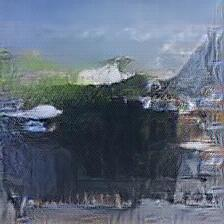

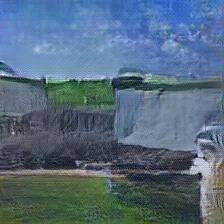

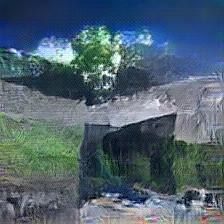

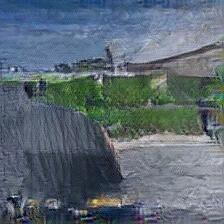

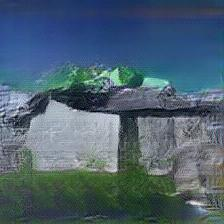

In [15]:
# Create output directory if it does not exist yet
if not os.path.exists(FOLDER):
    os.makedirs(FOLDER)
    
for n in range(max_img):    
    code = np.random.normal(0, 1, generator.blobs['feat'].data.shape)

    # Load the activation range
    upper_bound = lower_bound = None

    # Set up clipping bounds
    upper_bound = np.loadtxt(ap, delimiter=' ', usecols=np.arange(0, 4096), unpack=True)
    upper_bound = upper_bound.reshape(4096)

    # Lower bound of 0 due to ReLU
    lower_bound = np.zeros(4096)

    for i in range(total_iters):

        step_size = (alpha + (1e-10 - alpha) * i) / total_iters
        g, image = grad(classifier, 'data', 'prob', generator, 'feat', 'deconv0', SFW, 1., code)

        code = code - step_size*g/np.abs(g).mean()
        code = np.maximum(code, lower_bound) 
        code = np.minimum(code, upper_bound)

    show_image(image)
    save_image_numbered(image, n, FOLDER)

## Classification

To prove our hypothesis that open_nsfw was trained on a single ImageNet class used as an approximation of the non-concept of non-pornography, we classify the "SFW" images produced above by a network trained on ImageNet. We do this in Keras, so we have to use [a separate notebook running in a separate Docker container provided here](5-nsfw/classify.ipynb).

## Bibliography

- Dosovitskiy, Alexey, and Thomas Brox. "Generating Images with Perceptual Similarity Metrics Based on Deep Networks." In Advances in Neural Information Processing Systems, 658–66, 2016. http://papers.nips.cc/paper/6157-generating- images-with-perceptual-similarity-metrics-based-on-deep-networks.
- Nguyen, Anh, Alexey Dosovitskiy, Jason Yosinski, Thomas Brox, and Jeff Clune. "Synthesizing the Preferred Inputs for Neurons in Neural Networks via Deep Generator Networks." In Advances in Neural Information Processing Systems,
3387–95, 2016. http://papers.nips.cc/paper/6519-synthesizing-the-preferred- inputs-for-neurons-in-neural-networks-via-deep-generator-networks.
- Offert, Fabian. ""I know it when I see it". Visualization and Intuitive Interpretability". arXiv preprint arXiv:1711.08042, 2017. https://arxiv.org/abs/1711.08042